In [1]:
import pandas
import os
import spacy
import collections
import nltk
import wordcloud
import matplotlib.pyplot as plt
import plotly.express as px
import collections
import pysentimiento
import sentence_transformers
import numpy
import plotly.express as px
import simplemma

In [2]:
model_es = spacy.load("es_core_news_sm")
tk = nltk.TweetTokenizer()
analyzer = pysentimiento.create_analyzer(task="sentiment", lang="es")

In [3]:
def reemplazar_tildes(texto: str) -> str:
    reemplazos = {"á": "a", "é": "e", "í": "i", "ó": "o", "ú": "u"}
    for original, reemplazo in reemplazos.items():
        texto = texto.replace(original, reemplazo)
    return texto


def normalize_text(text: str) -> str:
    doc = model_es(" ".join(simplemma.text_lemmatizer(text, lang="es")))
    return " ".join([reemplazar_tildes(str(token)) for token in doc if token.is_alpha and not token.is_stop])

In [4]:
def count_no_stops(text: str) -> int:
    doc = model_es(text)
    return len([token for token in doc if token.is_alpha and not token.is_stop])


def most_important_no_stops(text: str) -> str:
    frequencies = dict(collections.Counter(text.split(" ")))
    return max(frequencies, key=frequencies.get)


def n_most_important_no_stops(text: str, n: int) -> list[str]:
    frequencies = dict(sorted(collections.Counter(text.split(" ")).items(), key=lambda item: item[1], reverse=True))
    return list(frequencies.keys())[:n]


def numero_oraciones(text: str) -> int:
    oraciones = nltk.tokenize.sent_tokenize(text, language="spanish")
    return len(oraciones)


def palabras_promedio_oraciones(text: str) -> float:
    oraciones = nltk.tokenize.sent_tokenize(text, language="spanish")
    longitud_promedio = sum(len(oracion.split()) for oracion in oraciones) / len(oraciones)
    return longitud_promedio


def n_most_important_bigrams(text: str, n: int) -> list[str]:
    tokens = nltk.word_tokenize(text)
    bigrams = list(nltk.bigrams(tokens))
    filtered_bigrams = [bigram for bigram in bigrams if len(bigram[0]) > 1 and len(bigram[1]) > 1 and len(bigram[0]) + len(bigram[1]) > 5]
    frequencies_bigrams = dict(sorted(collections.Counter(filtered_bigrams).items(), key=lambda x: x[1], reverse=True))
    return list(frequencies_bigrams.keys())[:n]

In [5]:
df_canciones = pandas.read_csv("../../../data/data.csv")
df_canciones = df_canciones.dropna(subset=["Cancion", "Titulo"])
df_canciones["tokens"] = df_canciones["Cancion"].apply(tk.tokenize)
df_canciones["size_tokens"] = df_canciones["tokens"].apply(len)
df_canciones["normalize"] = df_canciones["Cancion"].apply(normalize_text)
df_canciones = df_canciones[~(df_canciones["size_tokens"] < 10)].reset_index()
df_canciones = df_canciones.groupby(["Genero"]).agg({"Cancion": lambda x: " ".join(x), "normalize": lambda x: " ".join(x), "Artista": "count", "size_tokens": [("mean", "mean"), ("min", "min"), ("max", "max")]}).reset_index()
df_canciones.columns = ['_'.join(col).strip() for col in df_canciones.columns.values]
df_canciones = df_canciones.rename(columns={"Genero_": "genero", "Cancion_<lambda>": "cancion", "normalize_<lambda>": "normalize", "Artista_count": "n_canciones"})
df_canciones


,genero,cancion,normalize,n_canciones,size_tokens_mean,size_tokens_min,size_tokens_max
0,pop,"Llegó el momento, caen las murallas\r\nVa a co...",llegar momento caer muralla comenzar unico jus...,640,301.421875,36,790
1,reggaeton,"Me acostumbré al sour, ya no patea\r\nMe llega...",acostumbrar sour patear llegar casa capear mod...,600,523.935000,56,2018
2,rock,"De vuelta al goterón,que la injusticia da\r\na...",vuelta goteron injusticia amargo rastro lento ...,625,206.664000,33,1515
3,salsa,"Voy a reír, voy a bailar\r\nVivir mi vida, la-...",reir bailar vivir vida reir gozar vivir vida r...,599,314.075125,60,954
4,vallenato,Ay! Vamos a entonar una canción\r\nPa' que can...,ay entonar cancion pa cantar festejar emocion ...,600,318.495000,33,1041


In [6]:
df_canciones["tokens"] = df_canciones["cancion"].apply(tk.tokenize)
df_canciones

,genero,cancion,normalize,n_canciones,size_tokens_mean,size_tokens_min,size_tokens_max,tokens
0,pop,"Llegó el momento, caen las murallas\r\nVa a co...",llegar momento caer muralla comenzar unico jus...,640,301.421875,36,790,"[Llegó, el, momento, ,, caen, las, murallas, V..."
1,reggaeton,"Me acostumbré al sour, ya no patea\r\nMe llega...",acostumbrar sour patear llegar casa capear mod...,600,523.935000,56,2018,"[Me, acostumbré, al, sour, ,, ya, no, patea, M..."
2,rock,"De vuelta al goterón,que la injusticia da\r\na...",vuelta goteron injusticia amargo rastro lento ...,625,206.664000,33,1515,"[De, vuelta, al, goterón, ,, que, la, injustic..."
3,salsa,"Voy a reír, voy a bailar\r\nVivir mi vida, la-...",reir bailar vivir vida reir gozar vivir vida r...,599,314.075125,60,954,"[Voy, a, reír, ,, voy, a, bailar, Vivir, mi, v..."
4,vallenato,Ay! Vamos a entonar una canción\r\nPa' que can...,ay entonar cancion pa cantar festejar emocion ...,600,318.495000,33,1041,"[Ay, !, Vamos, a, entonar, una, canción, Pa, '..."


In [7]:
df_canciones["no_stops_x_cancion"] = df_canciones["normalize"].apply(lambda text: len(text.split(" "))) / df_canciones["n_canciones"]
df_canciones["palabra_mas_importante"] = df_canciones["normalize"].apply(lambda text: most_important_no_stops(text))
df_canciones["5_palabras_mas_importante"] = df_canciones["normalize"].apply(lambda text: n_most_important_no_stops(text, 10))
df_canciones["5_bigramas_mas_importante"] = df_canciones["cancion"].apply(lambda text: n_most_important_bigrams(text, 10))
df_canciones["riqueza_lexica"] = df_canciones["tokens"].apply(lambda tokens: len(set(tokens)) / len(tokens))
df_canciones["emociones"] = df_canciones["normalize"].apply(lambda text: analyzer.predict(text).output)
df_canciones["emociones_des"] = df_canciones["normalize"].apply(lambda text: {k: round(v, 4) for k, v in analyzer.predict(text).probas.items()})
df_canciones

,genero,cancion,normalize,n_canciones,size_tokens_mean,size_tokens_min,size_tokens_max,tokens,no_stops_x_cancion,palabra_mas_importante,5_palabras_mas_importante,5_bigramas_mas_importante,riqueza_lexica,emociones,emociones_des
0,pop,"Llegó el momento, caen las murallas\r\nVa a co...",llegar momento caer muralla comenzar unico jus...,640,301.421875,36,790,"[Llegó, el, momento, ,, caen, las, murallas, V...",102.554688,querer,"[querer, amor, vida, oh, corazon, i, volver, e...","[(te, quiero), (la, vida), (el, amor), (otra, ...",0.062459,NEU,"{'NEG': 0.1732, 'NEU': 0.6576, 'POS': 0.1692}"
1,reggaeton,"Me acostumbré al sour, ya no patea\r\nMe llega...",acostumbrar sour patear llegar casa capear mod...,600,523.935000,56,2018,"[Me, acostumbré, al, sour, ,, ya, no, patea, M...",182.538333,querer,"[querer, pa, baby, oh, to, amor, ere, sentar, ...","[(el, amor), (te, quiero), (la, vida), (la, di...",0.061977,NEU,"{'NEG': 0.0673, 'NEU': 0.8574, 'POS': 0.0753}"
2,rock,"De vuelta al goterón,que la injusticia da\r\na...",vuelta goteron injusticia amargo rastro lento ...,625,206.664000,33,1515,"[De, vuelta, al, goterón, ,, que, la, injustic...",74.102400,querer,"[querer, amor, vida, oh, volver, corazon, tiem...","[(la, vida), (el, tiempo), (como, un), (de, am...",0.103697,NEU,"{'NEG': 0.4197, 'NEU': 0.5573, 'POS': 0.023}"
3,salsa,"Voy a reír, voy a bailar\r\nVivir mi vida, la-...",reir bailar vivir vida reir gozar vivir vida r...,599,314.075125,60,954,"[Voy, a, reír, ,, voy, a, bailar, Vivir, mi, v...",112.168614,amor,"[amor, querer, vida, ay, corazon, sentar, pa, ...","[(la, vida), (tu, amor), (mi, vida), (te, quie...",0.071450,NEU,"{'NEG': 0.0874, 'NEU': 0.722, 'POS': 0.1906}"
4,vallenato,Ay! Vamos a entonar una canción\r\nPa' que can...,ay entonar cancion pa cantar festejar emocion ...,600,318.495000,33,1041,"[Ay, !, Vamos, a, entonar, una, canción, Pa, '...",104.763333,querer,"[querer, amor, vida, ay, corazon, pa, ere, vol...","[(mi, vida), (la, vida), (mi, amor), (tu, amor...",0.060854,POS,"{'NEG': 0.0127, 'NEU': 0.4101, 'POS': 0.5772}"


In [47]:
df_canciones.to_csv("./textometria.csv", index=False)

In [13]:
fig = px.bar(
    df_canciones,
    x="genero",
    y=["no_stops_x_cancion", "size_tokens_mean"],
    barmode="group",
    text_auto=True
)

fig.update_layout(
    autosize = False,
    height = 600,
    width = 1200,
    title="PROMEDIO TOKENS Y NO STOPWORDS X CANCIÖN",
    xaxis_title="Género",
    yaxis_title="Medida",
    legend_title="Leyenda",
    template="ggplot2",
)

fig.show()


In [9]:
df_canciones["POS"] = df_canciones["emociones_des"].apply(lambda d: d["POS"])
df_canciones["NEU"] = df_canciones["emociones_des"].apply(lambda d: d["NEU"])
df_canciones["NEG"] = df_canciones["emociones_des"].apply(lambda d: d["NEG"])

fig = px.bar(
    df_canciones,
    x="genero",
    y=["POS", "NEU", "NEG"],
    text_auto=".2%"
)

fig.update_layout(
    autosize = False,
    height = 600,
    width = 1400,
    title="EMOCIONES POSITIVO/NEUTRAL/NEGATIVO",
    xaxis_title="Presidente",
    yaxis_title="Porcentaje de sentimiento",
    legend_title="Leyenda",
    template="ggplot2",
)

fig.show()

### **Pop**

In [28]:
tokens_no_stop_pop = df_canciones.loc[0, "normalize"].split(" ")
text_pop = df_canciones.loc[0, "cancion"]

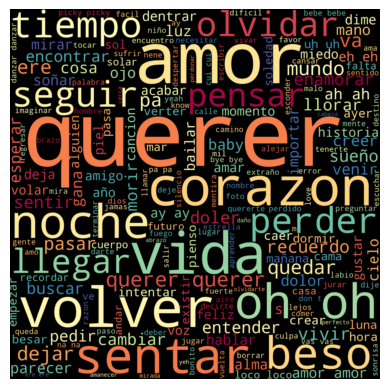

In [25]:
wc = wordcloud.WordCloud(width=1500, height=1500, colormap="Spectral")
wc.generate(" ".join(tokens_no_stop_pop))
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")

In [26]:
frequencies = dict(sorted(collections.Counter(tokens_no_stop_pop).items(), key=lambda item: item[1], reverse=True))

N = 50
fig = px.line(x=list(frequencies.keys())[:N], y=list(frequencies.values())[:N])
fig.update_layout(
    title="FRECUENCIA PALABRAS",
    autosize=False,
    width=900,
    height=400,
    template="ggplot2",
    xaxis_title="Palabras",
    yaxis_title="Frecuencia",
)
fig.show()

In [30]:
tokens = nltk.word_tokenize(text_pop)
bigrams = list(nltk.bigrams(tokens))
filtered_bigrams = [bigram for bigram in bigrams if len(bigram[0]) > 1 and len(bigram[1]) > 1 and len(bigram[0]) + len(bigram[1]) > 5]
frequencies_bigrams = dict(sorted(collections.Counter(filtered_bigrams).items(), key=lambda x: x[1], reverse=True))

N = 50
fig = px.line(x=list(map(str, frequencies_bigrams.keys()))[:N], y=list(frequencies_bigrams.values())[:N])
fig.update_layout(
    title="Bigramas",
    autosize=False,
    width=1200,
    height=500,
    template="ggplot2",
    xaxis_title="Bigramas",
    yaxis_title="Frecuencia",
)

### **Reggaeton**

In [31]:
tokens_no_stop_reggaeton = df_canciones.loc[1, "normalize"].split(" ")
text_reggaeton  = df_canciones.loc[1, "cancion"]

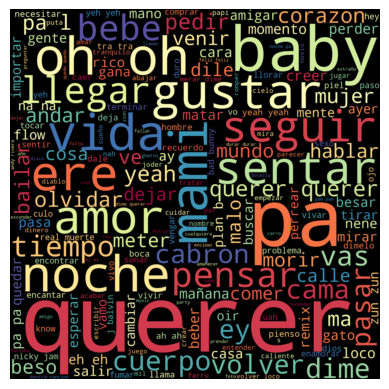

In [32]:
wc = wordcloud.WordCloud(width=1500, height=1500, colormap="Spectral")
wc.generate(" ".join(tokens_no_stop_reggaeton))
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")

In [33]:
frequencies = dict(sorted(collections.Counter(tokens_no_stop_reggaeton).items(), key=lambda item: item[1], reverse=True))

N = 50
fig = px.line(x=list(frequencies.keys())[:N], y=list(frequencies.values())[:N])
fig.update_layout(
    title="FRECUENCIA PALABRAS",
    autosize=False,
    width=900,
    height=400,
    template="ggplot2",
    xaxis_title="Palabras",
    yaxis_title="Frecuencia",
)
fig.show()

In [34]:
tokens = nltk.word_tokenize(text_reggaeton)
bigrams = list(nltk.bigrams(tokens))
filtered_bigrams = [bigram for bigram in bigrams if len(bigram[0]) > 1 and len(bigram[1]) > 1 and len(bigram[0]) + len(bigram[1]) > 5]
frequencies_bigrams = dict(sorted(collections.Counter(filtered_bigrams).items(), key=lambda x: x[1], reverse=True))

N = 50
fig = px.line(x=list(map(str, frequencies_bigrams.keys()))[:N], y=list(frequencies_bigrams.values())[:N])
fig.update_layout(
    title="Bigramas",
    autosize=False,
    width=1200,
    height=500,
    template="ggplot2",
    xaxis_title="Bigramas",
    yaxis_title="Frecuencia",
)

### **Rock**

In [35]:
tokens_no_stop_rock = df_canciones.loc[2, "normalize"].split(" ")
text_rock = df_canciones.loc[2, "cancion"]

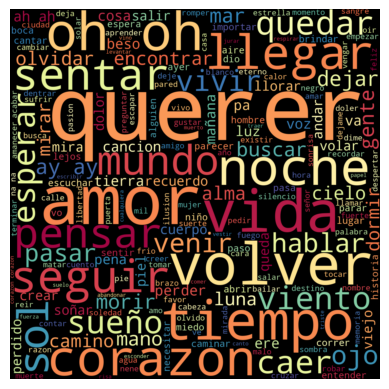

In [36]:
wc = wordcloud.WordCloud(width=1500, height=1500, colormap="Spectral")
wc.generate(" ".join(tokens_no_stop_rock))
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")

In [37]:
frequencies = dict(sorted(collections.Counter(tokens_no_stop_rock).items(), key=lambda item: item[1], reverse=True))

N = 50
fig = px.line(x=list(frequencies.keys())[:N], y=list(frequencies.values())[:N])
fig.update_layout(
    title="FRECUENCIA PALABRAS",
    autosize=False,
    width=900,
    height=400,
    template="ggplot2",
    xaxis_title="Palabras",
    yaxis_title="Frecuencia",
)
fig.show()

In [38]:
tokens = nltk.word_tokenize(text_rock)
bigrams = list(nltk.bigrams(tokens))
filtered_bigrams = [bigram for bigram in bigrams if len(bigram[0]) > 1 and len(bigram[1]) > 1 and len(bigram[0]) + len(bigram[1]) > 5]
frequencies_bigrams = dict(sorted(collections.Counter(filtered_bigrams).items(), key=lambda x: x[1], reverse=True))

N = 50
fig = px.line(x=list(map(str, frequencies_bigrams.keys()))[:N], y=list(frequencies_bigrams.values())[:N])
fig.update_layout(
    title="Bigramas",
    autosize=False,
    width=1200,
    height=500,
    template="ggplot2",
    xaxis_title="Bigramas",
    yaxis_title="Frecuencia",
)

### **Salsa**

In [39]:
tokens_no_stop_salsa = df_canciones.loc[3, "normalize"].split(" ")
text_salsa = df_canciones.loc[3, "cancion"]

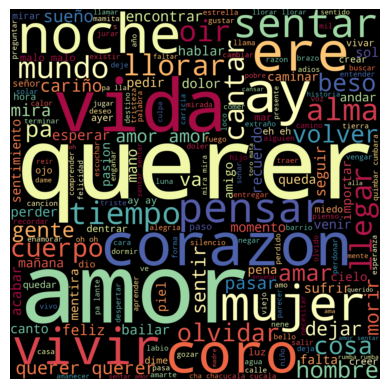

In [40]:
wc = wordcloud.WordCloud(width=1500, height=1500, colormap="Spectral")
wc.generate(" ".join(tokens_no_stop_salsa))
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")

In [41]:
frequencies = dict(sorted(collections.Counter(tokens_no_stop_salsa).items(), key=lambda item: item[1], reverse=True))

N = 50
fig = px.line(x=list(frequencies.keys())[:N], y=list(frequencies.values())[:N])
fig.update_layout(
    title="FRECUENCIA PALABRAS",
    autosize=False,
    width=900,
    height=400,
    template="ggplot2",
    xaxis_title="Palabras",
    yaxis_title="Frecuencia",
)
fig.show()

In [42]:
tokens = nltk.word_tokenize(text_salsa)
bigrams = list(nltk.bigrams(tokens))
filtered_bigrams = [bigram for bigram in bigrams if len(bigram[0]) > 1 and len(bigram[1]) > 1 and len(bigram[0]) + len(bigram[1]) > 5]
frequencies_bigrams = dict(sorted(collections.Counter(filtered_bigrams).items(), key=lambda x: x[1], reverse=True))

N = 50
fig = px.line(x=list(map(str, frequencies_bigrams.keys()))[:N], y=list(frequencies_bigrams.values())[:N])
fig.update_layout(
    title="Bigramas",
    autosize=False,
    width=1200,
    height=500,
    template="ggplot2",
    xaxis_title="Bigramas",
    yaxis_title="Frecuencia",
)

### **Vallenato**

In [43]:
tokens_no_stop_vallenato = df_canciones.loc[4, "normalize"].split(" ")
text_vallenato = df_canciones.loc[4, "cancion"]

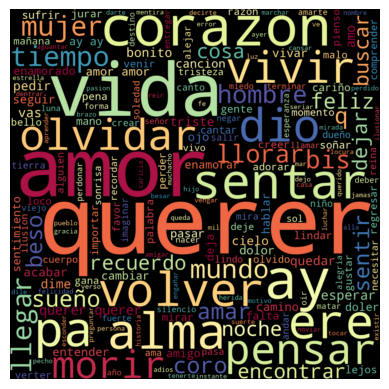

In [44]:
wc = wordcloud.WordCloud(width=1500, height=1500, colormap="Spectral")
wc.generate(" ".join(tokens_no_stop_vallenato))
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")

In [45]:
frequencies = dict(sorted(collections.Counter(tokens_no_stop_vallenato).items(), key=lambda item: item[1], reverse=True))

N = 50
fig = px.line(x=list(frequencies.keys())[:N], y=list(frequencies.values())[:N])
fig.update_layout(
    title="FRECUENCIA PALABRAS",
    autosize=False,
    width=900,
    height=400,
    template="ggplot2",
    xaxis_title="Palabras",
    yaxis_title="Frecuencia",
)
fig.show()

In [46]:
tokens = nltk.word_tokenize(text_vallenato)
bigrams = list(nltk.bigrams(tokens))
filtered_bigrams = [bigram for bigram in bigrams if len(bigram[0]) > 1 and len(bigram[1]) > 1 and len(bigram[0]) + len(bigram[1]) > 5]
frequencies_bigrams = dict(sorted(collections.Counter(filtered_bigrams).items(), key=lambda x: x[1], reverse=True))

N = 50
fig = px.line(x=list(map(str, frequencies_bigrams.keys()))[:N], y=list(frequencies_bigrams.values())[:N])
fig.update_layout(
    title="Bigramas",
    autosize=False,
    width=1200,
    height=500,
    template="ggplot2",
    xaxis_title="Bigramas",
    yaxis_title="Frecuencia",
)